1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd

N = 100000
filepath = './data/data_000637.txt'

df = pd.read_csv(filepath, sep=',', header=0, nrows=N)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
99995,1,0,64,3869201161,2378,29
99996,1,0,70,3869201161,2472,26
99997,1,0,58,3869201161,2558,0
99998,1,0,57,3869201161,2561,23


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
bx_rows = df[df['BX_COUNTER'] == 0]

difference = bx_rows['ORBIT_CNT'].diff()

x = difference.mean()

print(f"Estimated value of x (number of BX in an ORBIT): {int(x)}")

Estimated value of x (number of BX in an ORBIT): 33


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [7]:
df['ABSOLUTE_TIME'] = (
    df['ORBIT_CNT'] * x * 25 +  
    df['BX_COUNTER'] * 25 +  
    df['TDC_MEAS'] * (25 / 30) 
)

start_time_offset = df['ABSOLUTE_TIME'].min()
df['ABSOLUTE_TIME'] -= start_time_offset

df['ABSOLUTE_TIME'] = pd.to_datetime(df['ABSOLUTE_TIME'], unit='ns')
print(df[['HEAD', 'FPGA', 'TDC_CHANNEL', 'ABSOLUTE_TIME']])

       HEAD  FPGA  TDC_CHANNEL                 ABSOLUTE_TIME
0         1     0          123 1970-01-01 00:00:00.000058352
1         1     0          124 1970-01-01 00:00:00.000058353
2         1     0           63 1970-01-01 00:00:00.000062829
3         1     0           64 1970-01-01 00:00:00.000062947
4         1     0           64 1970-01-01 00:00:00.000068002
...     ...   ...          ...                           ...
99995     1     0           64 1970-01-01 00:00:00.000883830
99996     1     0           70 1970-01-01 00:00:00.000886177
99997     1     0           58 1970-01-01 00:00:00.000888306
99998     1     0           57 1970-01-01 00:00:00.000888400
99999     1     0           56 1970-01-01 00:00:00.000888491

[100000 rows x 4 columns]


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [13]:
# Calculate the duration of the data taking
duration = df['ABSOLUTE_TIME'].max() - df['ABSOLUTE_TIME'].min()

print(df['ABSOLUTE_TIME'].max())
print(df['ABSOLUTE_TIME'].min())
print(duration)
# Extract hours, minutes, and seconds from the duration
hours = duration.components.hours
minutes = duration.components.minutes
seconds = duration.components.seconds

# Display the results
# print(f"Duration: {hours} hours, {minutes} minutes, {seconds} seconds")

1970-01-01 00:00:00.000912417
1970-01-01 00:00:00
0 days 00:00:00.000912417


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [14]:

# Group by 'TDC_CHANNEL' and count occurrences
channel_counts = df.groupby('TDC_CHANNEL').size().reset_index(name='count')

# Sort the channels by count in descending order
channel_counts = channel_counts.sort_values(by='count', ascending=False)

# Display the top 3 noisy channels and their counts
top_noisy_channels = channel_counts.head(3)
print("Top 3 Noisy Channels:")
print(top_noisy_channels)

Top 3 Noisy Channels:
     TDC_CHANNEL  count
132          139   8320
63            64   5027
62            63   4917


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [15]:
# Filter out rows with at least one hit
non_empty_orbits = df[df['HEAD'] == 1]

# Count the number of non-empty orbits
num_non_empty_orbits = non_empty_orbits['ORBIT_CNT'].nunique()

# Display the result
print("Number of Non-Empty Orbits:", num_non_empty_orbits)

Number of Non-Empty Orbits: 995


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [16]:
# Filter rows with TDC_CHANNEL=139 and HEAD=1
tdc_139_rows = df[(df['TDC_CHANNEL'] == 139) & (df['HEAD'] == 1)]

# Count the number of unique orbits
num_unique_orbits_tdc_139 = tdc_139_rows['ORBIT_CNT'].nunique()

# Display the result
print("Number of Unique Orbits with TDC_CHANNEL=139:", num_unique_orbits_tdc_139)

Number of Unique Orbits with TDC_CHANNEL=139: 994


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [17]:

# Group by 'FPGA' and 'TDC_CHANNEL' and count occurrences
channel_counts_by_fpga = df.groupby(['FPGA', 'TDC_CHANNEL']).size().reset_index(name='count')

# Separate the counts for each FPGA into two Series
fpga1_series = channel_counts_by_fpga[channel_counts_by_fpga['FPGA'] == 0].set_index('TDC_CHANNEL')['count']
fpga2_series = channel_counts_by_fpga[channel_counts_by_fpga['FPGA'] == 1].set_index('TDC_CHANNEL')['count']

# Display the resulting Series
print("FPGA 1 Series:")
print(fpga1_series.head())

print("\nFPGA 2 Series:")
print(fpga2_series.head())

FPGA 1 Series:
TDC_CHANNEL
1     91
2    109
3    118
4    148
5    121
Name: count, dtype: int64

FPGA 2 Series:
TDC_CHANNEL
1    2116
2    2444
3    1670
4    2014
5    1151
Name: count, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

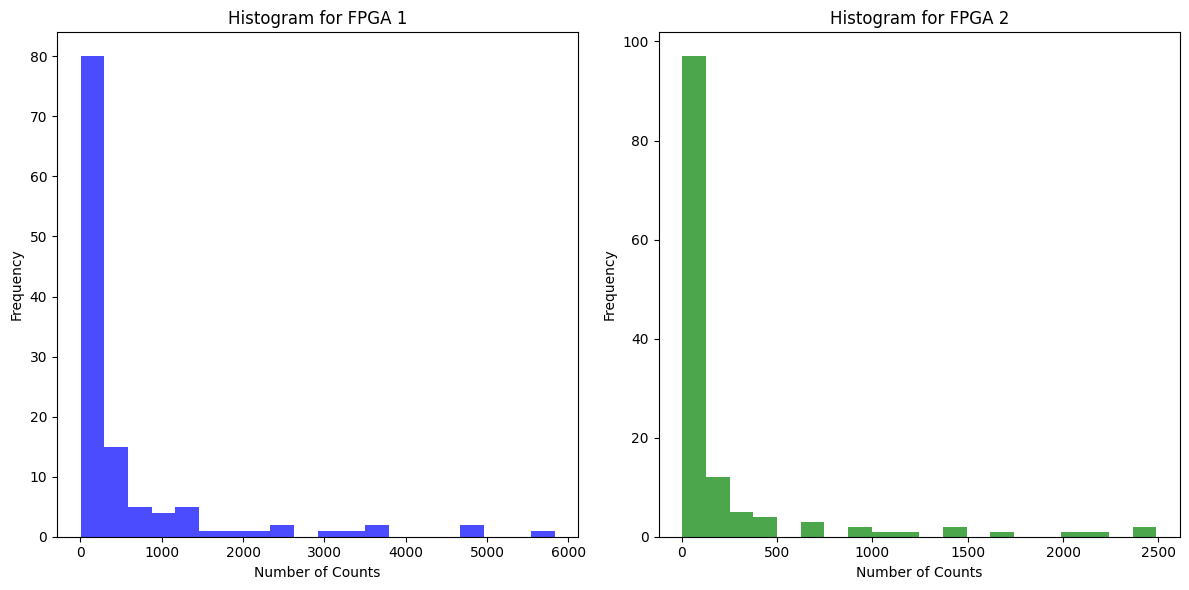

In [20]:
import matplotlib.pyplot as plt

# Group by 'FPGA' and 'TDC_CHANNEL' and count occurrences
channel_counts_by_fpga = df.groupby(['FPGA', 'TDC_CHANNEL']).size().reset_index(name='count')

# Separate the counts for each FPGA into two Series
fpga1_series = channel_counts_by_fpga[channel_counts_by_fpga['FPGA'] == 0].set_index('TDC_CHANNEL')['count']
fpga2_series = channel_counts_by_fpga[channel_counts_by_fpga['FPGA'] == 1].set_index('TDC_CHANNEL')['count']

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fpga1_series, bins=20, color='blue', alpha=0.7)
plt.title('Histogram for FPGA 1')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(fpga2_series, bins=20, color='green', alpha=0.7)
plt.title('Histogram for FPGA 2')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()